<a href="https://colab.research.google.com/github/Inigofs/kschool-dl/blob/main/bdl_teacher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Deep Learning (BDL)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.9.2
TFP version: 0.17.0


In [ ]:
# Additional imports and setting fixed random seed to have reproducibility

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
tf.random.set_seed(123)

In [ ]:
#@title Utils { display-mode: "form" }
def print_subclasses_from_module(module, base_class, maxwidth=80):
    import functools, inspect, sys
    subclasses = [name for name, obj in inspect.getmembers(module)
                if inspect.isclass(obj) and issubclass(obj, base_class)]
    def red(acc, x):
        if not acc or len(acc[-1]) + len(x) + 2 > maxwidth:
            acc.append(x)
        else:
            acc[-1] += ", " + x
        return acc
    print('\n'.join(functools.reduce(red, subclasses, [])))

In [ ]:
eps = 0.01
def plot_g(ax, mu, sigma, args={}):
    x = np.linspace(-5, 5, 1000)
    y = norm.pdf(x, loc=mu, scale=sigma**2.)
    return ax.plot(x,y, linewidth=2., label='m='+str(mu)+', s='+str(sigma), **args)

def plot_v(ax, x0, y0, c):
    x = [x0 - eps, x0 + eps]
    y = [0, y0]
    return ax.step(x, y, linewidth=5., c=c, label='pdf='+str(y0))

def plot_2d_in_3d(f, sigma, args={'linewidth': 2.}):
    x = np.linspace(-5, 5, 1000)
    y = f(x)
    return ax.plot(x, y, zs=sigma, zdir='y', **args)
    
def plot_1d_in_3d(sigma, f, t, zdir='y', args={'linewidth': 2.}):
    x = np.linspace(f, t, 1000)
    y = 0 * x
    return ax.plot(x, y, zs=sigma, zdir=zdir, **args)
    
def plot_v_in_3d(x0, y0, z0, c):
    return plot_2d_in_3d(lambda x: z0 * (x0 - eps < x) * (x < x0 + eps), y0, {'linewidth': 5., 'c': c})

def plot_3d_g(mu, sigma, sigma0):
    return plot_2d_in_3d(lambda x: norm.pdf(x, loc=mu, scale=sigma**2.), sigma=sigma0)

def plot_sigma_constant(sigma0):
    return plot_1d_in_3d(sigma0, -5, 5, zdir='y')

def plot_mu_constant(mu0):
    return plot_1d_in_3d(mu0, 0, 2, zdir='x')

In [ ]:
def scatter_histogram(x1, x2, x_lim=None, y_lim=None):
  fig, ax = plt.subplots(figsize=(7, 7))
  ax.scatter(x1, x2)
  ax.set_aspect(1.)
  divider = make_axes_locatable(ax)
  ax_histx = divider.append_axes("top", 1.2, pad=0.1, sharex=ax)
  ax_histy = divider.append_axes("right", 1.2, pad=0.1, sharey=ax)
  ax_histx.xaxis.set_tick_params(labelbottom=False)
  ax_histy.yaxis.set_tick_params(labelleft=False)
  binwidth = 0.25
  xymax = max(np.max(np.abs(x1)), np.max(np.abs(x2)))
  lim = (int(xymax/binwidth) + 1)*binwidth
  bins = np.arange(-lim, lim + binwidth, binwidth)
  ax_histx.hist(x1, bins=bins)
  ax_histy.hist(x2, bins=bins, orientation='horizontal')
  if x_lim is not None:
    assert type(x_lim) == list, "list of len 2 is required"
    assert len(x_lim) == 2, "list of len 2 is required"
    ax.set_xlim(x_lim[0], x_lim[1])
  if y_lim is not None:
    assert type(y_lim) == list, "list of len 2 is required"
    assert len(y_lim) == 2, "list of len 2 is required"
    ax.set_ylim(y_lim[0], y_lim[1])
  plt.show()

***
# Introduction

![](https://alexgkendall.com/assets/images/blog_uncertainty/uncertainty_types.jpg)
<sub>_Illustrating the difference between aleatoric and epistemic uncertainty for semantic segmentation. You can notice that aleatoric uncertainty captures object boundaries where labels are noisy. The bottom row shows a failure case of the segmentation model, when the model is unfamiliar with the footpath, and the corresponding increased epistemic uncertainty_</sub>


Generally speaking, conventional neural networks (NN) are well designed to calculate point estimates of any quantity of interest. However, NN can not deal with uncertainties on their own, and require of new tools to become a truly probabilistic framework. 

In this notebook, we will see how Bayesian inference methods can help us to fix some of the shortcomings of deep learning, in particular, those related with the notion of uncertainty and confidence about the network predictions. 

We will learn about the following topics:

## Outline
#### 1. [Motivation](#motivation)
#### 2. [Bayesian Formalism](#bayesian_formalism)
- ##### 2.1. [Bayes Formula](#bayes_formula)
- ##### 2.2. [Variational Inference & MonteCarlo Methods](#vi_mc)

#### 3. [Tour of Tensorflow Probability](#tfp_basics)
- ##### 3.1. [Univariate or scalar-variate Distributions](#univariate_distributions)
- ##### 3.2. [Multivariate or vector-variate Distributions](#multivariate_distributions)
- ##### 3.3. [The Independent Distribution](#independent_distribution)
- ##### 3.4. ["Learnable" Distributions](#trainable_distributions)

#### 4. [Bayesian Neural Networks](#bayesian_nn)
- ##### 4.1. [Preliminars: The DistributionLambda layer](#lambda_layer)
- ##### 4.2. [Aleatoric Uncertainty](#aleatoric)
- ##### 4.3. [Epistemic Uncertainty & DenseVariational layer](#epistemic)
- ##### 4.4. [Aleatoric + Epistemic Uncertainty](#aleatoric+epistemic)
- ##### 4.5. [Dropout & Epistemic Uncertainty](#dropout)
- ##### 4.6. [Reparameterization layers](#reparameterization_layer)

***
## 1. Motivation
<a name="motivation"></a>
<a id='motivation'></a>

Measurement uncertainty is critical in a wide range of fields such as risk assessment, decision making, physics or life science. In such fields it is
quite important to quantify our confidence about the models’ predictions.

In this sense, uncertainty provides us with a mechanism for discerning what our model knows or ignores, and it helps us to bring insights into the model when it fails.

***
**Medical Diagnostics - diabetic retinopathy**

![](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/BDL/DIAbetes.png?raw=1)

Which model f1, f2 would you want to use for your diagnosis? **None of these!**

***
**First fatality of assisted driving (June 2016)**

![](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/BDL/Tesla_A_tragic_loss.png?raw=1)

If system had identified its own uncertainty:
- alert user to take control over steering
- propagate uncertainty to decision making

<div class  = "alert alert-info"> 
In medical / robotics / science...
    
- can’t use ML models giving a single point estimate (single value) in prediction
- must use ML models giving an answer that says ‘10 but I’m uncertain’; or ‘10 ± 5’
    
<b>Give me a distribution over possible outcomes!</b>
</div>

***
**Sources of uncertainty**
- test data is very dissimilar to training data. Ex: model trained on diabetes fondus photos of subpopulation A never saw subpopulation B --> images are outside data distribution model was trained on

![](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/BDL/Aleatoric.png?raw=1)

- Uncertainty in model parameters that best explain data

I large number of possible models can explain a dataset

I uncertain which model parameters to choose to predict with

I affects how we predict with new test points

![](https://github.com/FasterUpperBeyond/deep-learning-images/blob/master/imgs/BDL/Epistemic.png?raw=1|width=10height=10)

<div class  = "alert alert-info"> 
<b>Deep learning models are deterministic</b> Deep learning does not capture uncertainty
    
But when combined with <b>probability theory</b> can capture uncertainty in
a principled way. This is known as <b>Bayesian Deep Learning</b>
</div>

***
**Applications of Bayesian Deep Learning**
- Active learning

![](https://images.deepai.org/glossary-terms/46a6b355896c490cae75d2a0a15d4f65/active-learning.jpg)

- More applications:
    -  [Leveraging uncertainty information from deep neural networks for disease detection](https://www.researchgate.net/publication/321788243_Leveraging_uncertainty_information_from_deep_neural_networks_for_disease_detection)
    - [Uncertainty-Aware Reinforcement Learning for Collision Avoidance](https://arxiv.org/abs/1702.01182)
    - [Semantic Segmentation of Small Objects and Modeling of Uncertainty in Urban Remote Sensing Images Using Deep Convolutional Neural Network](https://www.researchgate.net/publication/309787025_Semantic_Segmentation_of_Small_Objects_and_Modeling_of_Uncertainty_in_Urban_Remote_Sensing_Images_Using_Deep_Convolutional_Neural_Networks)
    - [Uncertainties in parameters estimated with neural networks: applications to strong gravitational lensing](https://arxiv.org/abs/1708.08843)
    - [Engineering uncertainty estimation in neural networks for time series prediction](https://eng.uber.com/neural-networks-uncertainty-estimation/)


***
## 2. Bayesian Formalism
<a name="bayesian_formalism"></a>
<a id='bayesian_formalism'></a>

Bayesian methods represent one common framework in which to conduct statistical inference. In this section, we provide a very short introduction of the topic.

### 2.1. Bayes Formula
<a name="bayes_formula"></a>
<a id='bayes_formula'></a>

Bayes Theorem provides a principled way for calculating a conditional probability. In simple terms, Bayes theorem computes the probability of a hypothesis (or parameter) $H$ based on its prior probability, the probabilities of observing various data $D$ --source of information in this case-- given the hypothesis, and the observed data itself. 

*Note how the unknown parameter o hypothesis $h$ is now a random variable, in contrast with the typical 
frequentist approach

In the discrete domain, Bayes Formula adopts the following expression:

$$P(h|D) = \frac{P(D|h) P(h)}{P(D)}$$

where

- $P(h|D)$: denotes the posterior probability of the hypothesis (the thing we want to calculate). It summarises the information about $h$ after observing the data $D$.

- $P(h)$: is the prior probability of the hypothesis. If we do not have any prior information about the hypothesis being tested, it can be assigned as a uniform probability

- $P(D)$: is the probability of the data. According to the Law of total probability, $P(D)$ can be expressed as follows:

$$P(D) = \sum_n P(D|h_n) P(h_n) $$

with $P(h_n)$ the probability of each hypothesis. Note how this quantity is independent of the parameter or hypothesis $h$.

**[Who took the cookie from the A cookie jar?... Who me? I'm not sure!](https://supersimple.com/song/who-took-the-cookie/)** 

Suppose there are two bowls of cookies. Bowl 1 contains 30 vanilla
cookies and 10 chocolate cookies. Bowl 2 contains 20 of each.
Now suppose you choose one of the bowls at random and, without looking, select a
cookie at random. The cookie is vanilla. What is the probability that it came from Bowl
1?

In [ ]:
# Translate data into evidences, priors and likelihoods
vanilla_problem = {'vanilla': {'bowl1': 3. / 4, 'bowl2': 1. / 2}, 
                   'chocolate': {'bowl1': 1. / 4, 'bowl2': 1. / 2}}

In [ ]:
# Implement discrete Bayes formula
class bayes_discrete():
    def __init__(self, evidence, queried_state, likelihood_dict, priors=None):
        self.evidences = list(likelihood_dict.keys())
        self.evidence = evidence
        self.states = list(likelihood_dict[self.evidences[0]].keys())
        self.state = queried_state
        self.n_states = len(self.states)
        self.probabilities = np.array([likelihood_dict[self.evidence][s] for s in self.states])
        self.prior(priors)
        self.likelihood = likelihood_dict[evidence][queried_state]
    
    def prior(self, p=None):
        if p:
            self.prs = np.array([p[s] for s in self.states])
            self.pr = p[self.state]
        else:
            self.prs = np.ones(self.n_states) / self.n_states
            self.pr = 1. / self.n_states
    
    def posterior(self):
        total_probability = self.total_probability()
        posterior = self.likelihood * self.pr / total_probability
        return posterior
    
    def total_probability(self):
        total = np.sum(self.probabilities * self.prs)
        return total

In [ ]:
# Solve cookie problem
cookie_problem = bayes_discrete('vanilla', 'bowl1', 
                                vanilla_problem)
cookie_problem.posterior()

0.6

A similiar expression can be obtained for the continuous case:

$$p(h|D) = \frac{f(D|h) f(h)}{\int f(D|h) f(h) dh}$$

but now we work in terms of density functions and replace sums by integrals.

The term $f(D|h)$ is called the likelihood function $L(h)$. As the denominator is independent of the hypothesis, the density of the posterior distribution is  proportional to the product of the likelihood and the density of the prior distribution

$$f(h | D) \propto f (D | h)f (h) = L(h) f (h)$$

Under a uniform prior, we can observe that the posterior mode 
$$arg max_h f (h| D)$$ 

equals the common maximum likelihood estimation (MLE). 

In fact, seeking the hypothesis with the maximum posterior probability --that is, the best one which explained the observed data -- implies the resolution of this optimization problem known as  maximum a posteriori or MAP. 

Fitting models like linear regression for predicting a numerical value (as in the next sections), and logistic regression for binary classification can be framed and solved under the MAP probabilistic framework.

**Can you find my Gaussian? Visualising Gaussian likelihoods.**

Assuming Gaussian densities with $\sigma = 1$, what’s the probability that any $\mu \in \left(-2, -1, 0, 1, 2 \right)$ generates my data?

In [ ]:
# Our data

D = np.array([0.0])

In [ ]:
# Plot the data 

def plot_bf_ex1(D):
    plt.figure(figsize=(5,4))
    plt.xlabel('x')
    plt.ylabel('')
    plt.xlim(-5, 5)
    plt.ylim(0, 1)
    plt.scatter(D, [0 for x in D], s=100, linewidth=4, c='k', marker='x', clip_on=False)
    plt.title("Data space")

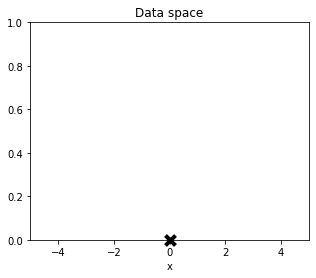

In [ ]:
plot_bf_ex1(D)

hypotheses:

In [ ]:
# hypothesis
mu_m = [-2, -1, 0, 1, 2]
s_m = [1, 1, 1, 1, 1]

Text(0.5, 1.0, 'Hypothesis space')

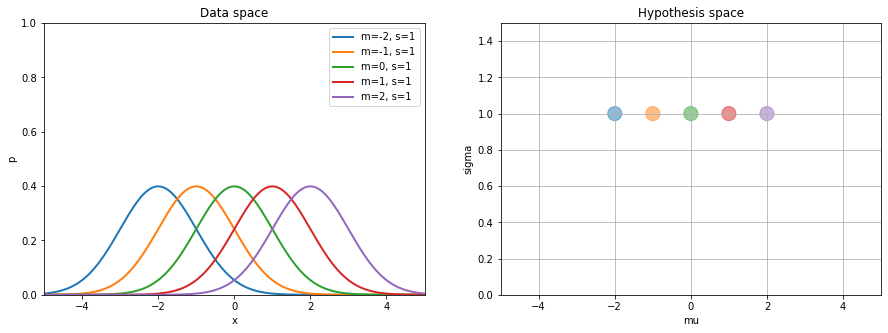

In [ ]:
# Plot both data space and hypothesis space
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_xlabel('x')
ax1.set_ylabel('p')
ax1.set_xlim(-5, 5)
ax1.set_ylim(0, 1)

pm = []
for m, s in zip(mu_m, s_m):
    pm += plot_g(ax=ax1, mu=m, sigma=s)
ax1.legend()
ax1.set_title("Data space")

ax2.set_xlabel('mu')
ax2.set_ylabel('sigma')
ax2.set_xlim(-5, 5)
ax2.set_ylim(0, 1.5)
ax2.grid(True)
ax2.scatter(mu_m, s_m, s=200, alpha=0.5, c=[g.get_color() for g in pm])
ax2.set_title("Hypothesis space")

The likelihood for our single data point looks like:

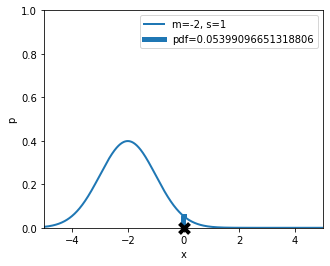

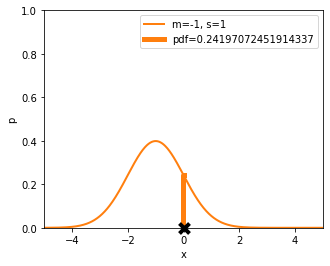

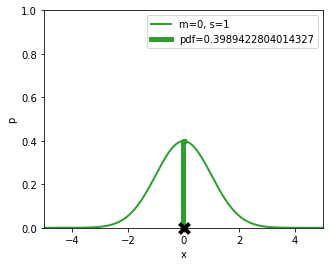

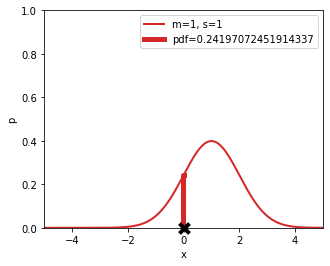

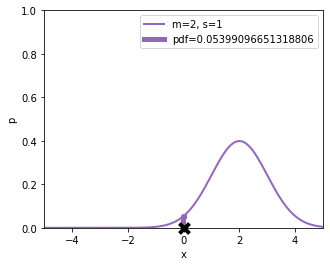

In [ ]:
# Get and plot the likelihood
D0 = [D[0]]
for m, s, p in zip(mu_m, s_m, pm):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.set_xlabel('x')
    ax.set_ylabel('p')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 1)
    plot_g(ax=ax, mu=m, sigma=s, args={'c': p.get_color()})
    
    for x in D0:
        mu, sigma = m, s
        pdf = norm.pdf(x, loc=mu, scale=sigma**2.)
        plot_v(ax, x, pdf, c=p.get_color())
    ax.legend()
    ax.scatter(D0, [0 for x in D0], s=100, linewidth=4, c='k', marker='x', clip_on=False, zorder=10)

Let's compare all likelihoods for a single point in hypothesis space

Text(5, 1, 's=1')

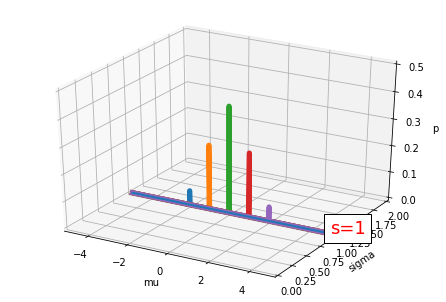

In [ ]:
# Compare the likelihoods in the hypothesis space
fig = plt.figure()
ax = Axes3D(fig)
ax.invert_yaxis()
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
ax.set_zlabel("p")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 2)
ax.set_zlim(0, 0.5)
for x in D0:
    for m, s, p in zip(mu_m, s_m, pm):
        pdf = norm.pdf(x, loc=m, scale=s**2.)
        plot_v_in_3d(m, s, pdf, c=p.get_color())
plot_sigma_constant(s)
ax.text(5, s, 0, 's='+str(s), color='r', fontsize=18, 
         bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.),
                   ))

In [ ]:
# Compare some more hypotheses, considering this time different $\sigma$ values
mu_s = [0, 0, 0, 0]
s_s = list(reversed([0.1, 0.5, 0.8, 1.]))

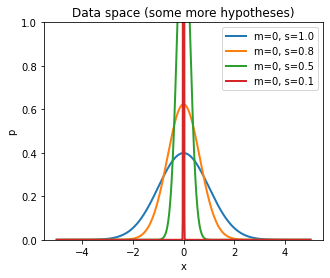

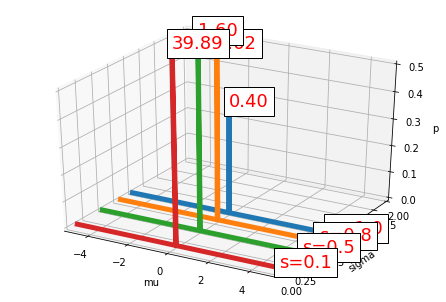

In [ ]:
# As before, plot the data and hypothesis spaces
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
ax.set_xlabel('x')
ax.set_ylabel('p')
ax.set_ylim(0, 1)

ps = []
for m, s in zip(mu_s, s_s):
    ps += plot_g(ax=ax, mu=m, sigma=s)
ax.legend()
ax.set_title("Data space (some more hypotheses)")


fig = plt.figure()
ax = Axes3D(fig)
ax.invert_yaxis()
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
ax.set_zlabel("p")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 2)
ax.set_zlim(0, 0.5)
for x in D0:
    for m, s, p in zip(mu_s, s_s, ps):
        pdf = norm.pdf(x, loc=m, scale=s**2.)
        pdf_t = "{:.2f}".format(pdf)
        pdf = np.clip(pdf, 0, 0.7)
        plot_v_in_3d(m, s, pdf, c=p.get_color())
        ax.text(m, s, pdf, pdf_t, color='r', fontsize=18, 
                 bbox=dict(boxstyle="square",
                           ec=(0., 0., 0.),
                           fc=(1., 1., 1.),
                           ))
        ax.text(5, s, 0, 's='+str(s), color='r', fontsize=18, 
                 bbox=dict(boxstyle="square",
                           ec=(0., 0., 0.),
                           fc=(1., 1., 1.),
                           ))

Ex. Repeat the exercise, this time with some more data (assumed data comes iid from a Gaussian)...

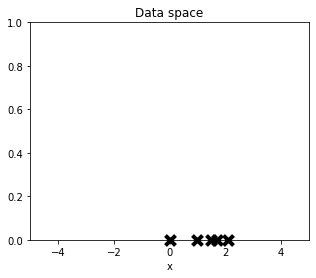

In [ ]:
# Input data
D = np.array([0.6, 1.6, 2.1, 2.3, 2.7]) - 0.6
plot_bf_ex1(D)

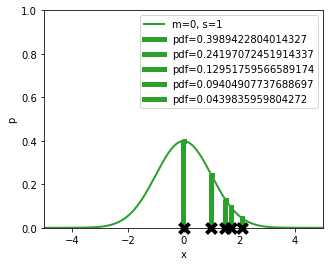

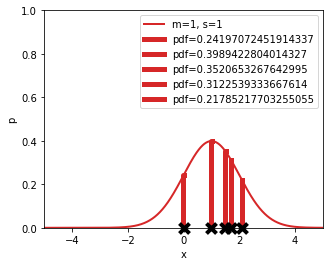

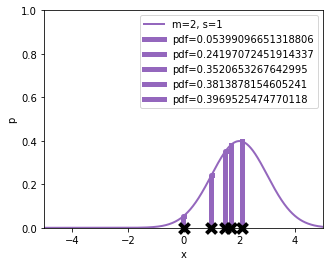

In [ ]:
# plot the likelihoods in data space
for m, s, p in zip(mu_m[2:], s_m[2:], pm[2:]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    ax.set_xlabel('x')
    ax.set_ylabel('p')
    ax.set_xlim(-5, 5)
    ax.set_ylim(0, 1)
    plot_g(ax=ax, mu=m, sigma=s, args={'c': p.get_color()})
    plt.legend()
    for x in D:
        mu, sigma = m, s
        pdf = norm.pdf(x, loc=mu, scale=sigma**2.)
        plot_v(ax, x, pdf, c=p.get_color())
        ax.legend()
    ax.scatter(D, [0 for x in D], s=100, linewidth=4, c='k', marker='x', clip_on=False, zorder=10)

Text(5, 1, 's=1')

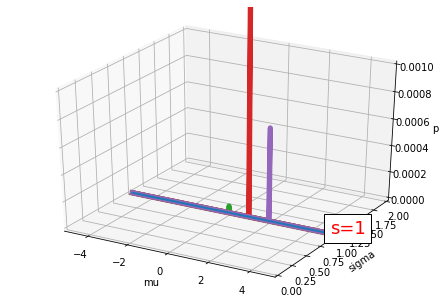

In [ ]:
# Plot results in hypothesis space
fig = plt.figure()
ax = Axes3D(fig)
ax.invert_yaxis()
ax.set_xlabel("mu")
ax.set_ylabel("sigma")
ax.set_zlabel("p")
ax.set_xlim(-5, 5)
ax.set_ylim(0, 2)
ax.set_zlim(0, 0.001)
for m, s, p in zip(mu_m, s_m, pm):
    pdf = 1.
    for x in D:
        pdf *= norm.pdf(x, loc=m, scale=s**2.)
    plot_v_in_3d(m, s, pdf, c=p.get_color())
plot_sigma_constant(s)
ax.text(5, s, 0, 's='+str(s), color='r', fontsize=18, 
         bbox=dict(boxstyle="square",
                   ec=(0., 0., 0.),
                   fc=(1., 1., 1.),
                   ))

***
### 2.2. Variational Inference & MonteCarlo Methods
<a name="vi_mc"></a>
<a id='vi_mc'></a>

The above formula gives a way to determine the posterior distribution of an hypothesis (in our case, the weight in a neural network):
1. Pick a prior density $P(w)$.
2. Using training data $D$, determine the likelihood $P(D | w)$.
3. Determine the posterior density $P(w | D)$ using Bayes' theorem. This is the distribution of the hypothesis $w$.

While this works in principle, in many practical settings it is difficult to implement. The main reason is that the normalisation constant 

$${\int P(D | w') P(w') \text{d}w'} = P(D)$$ 

may be very difficult to calculate, as it involves solving or approximating a complicated integral. For this reason, approximate methods, such as *Variational Inference* or *Monte Carlo Methods* described below, are often employed.

**Variational Inference**.- Variational Inference (VI) is a method for approximating probability densities through optimization.

__How is it done.__ Consider a family of distributions denoted $q(z|\phi)$ parametrised by vector $\phi \in \Phi$ which approximate $p(z|x)$. The idea of VI is to find the best approximation of the posterior via:

$$\phi_* = arg min_{\phi \in \Phi} KL \left(q(z|\phi) || p(z | x) \right)$$

i.e. find $\phi_*$ which minimises the Kullback Leibler divergence, which in short is an asymmetric measure of the difference in two probability distributions. In other words, the steps for turning the inference problem into an optimization problem are:

- Posit a family of approximate densities $Q$ over the latent variables $\phi$ (parameters we want to estimate,  as the weights of a network, for example).

- Try to find the member of that family that minimizes the Kullback-Leibler
divergence to the exact posterior

- Approximate the posterior with the optimized member of the family $q^*$

Unfortunately, we can't really compute the KL divergence because it involves the posterior. Instead, the problem is changed to maximising what is known as the evidence lower bound (ELBO).

__ELBO Derivation.__

$$KL(q(z|\phi)||p(z|x))=\int_{-\infty}^{\infty} q(z|\phi)\log\left(\frac{q(z|\phi)}{p(z|x)}\right)dz = ... \
= 𝔼_{q(z|\phi)}(\log(q(z|\phi))−𝔼_{q(z|\phi)}(\log(p(z,x)))+\log(p(x))$$

From where:
$$\log(p(x)) = KL(q(z|\phi)||p(z|x)) + 𝔼_{q(z|\phi)}(\log(p(z,x))) - 𝔼_{q(z|\phi)}(\log(q(z|\phi))$$

Noting that 
$$KL(q(z|\phi)||p(z|x)) \geq 0$$

we obtain a lower bound for the evidence (ELBO):

$$\log(p(x)) \geq 𝔼_{q(z|\phi)}(\log(p(z,x))) - 𝔼_{q(z|\phi)}(\log(q(z|\phi)) = ELBO(\phi)$$

From a practical perspective, variational inference methods can be found in TensorFlow Probability as well [link](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/vi).



**Monte Carlo Methods**.- The other well known methods for computing approximately a posterior distribution corresponds to the Monte Carlo ones (MC). MC finds approximate solutions through random sampling, that is, it approximates the probability of an outcome by running multiple trails.

In order to understand better how MC works, let us solve the next exercise.

__Ex: Estimating the value of pi using Monte Carlo__

Approximate value of pi is 3.108


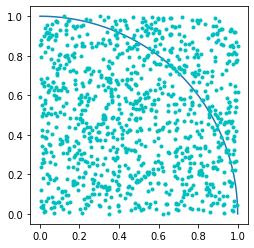

In [ ]:
square_size = 1
points_inside_circle = 0
points_inside_square = 0
sample_size = 1000
arc = np.linspace(0, np.pi/2, 100)

def generate_points(size):
    x = np.random.random()*size
    y = np.random.random()*size
    return (x, y)

def is_in_circle(point, size):
    return np.sqrt(point[0]**2 + point[1]**2) <= size

def compute_pi(points_inside_circle, points_inside_square):
    return 4 * (points_inside_circle / points_inside_square)

plt.axes().set_aspect('equal')
plt.plot(1*np.cos(arc), 1*np.sin(arc))


for i in range(sample_size):
    point = generate_points(square_size)
    plt.plot(point[0], point[1], 'c.')
    points_inside_square += 1
    
    if is_in_circle(point, square_size):
        points_inside_circle += 1

print("Approximate value of pi is {}".format(compute_pi(points_inside_circle, points_inside_square)))

Inside the MC family of methods, Markov chain Monte Carlo (MCMC) are the most relevant ones. The basic idea here is to simulate a Markov chain
$h(1),..., h(m),...$ , which is designed to converge to the posterior distribution $f(h|D)$. After convergence we simply need to obtain samples to draw the
posterior distribution or compute any basic statistic of interest.

Check out this [great animation](https://chi-feng.github.io/mcmc-demo/app.html#HamiltonianMC,banana) by Chi Feng to see how different MCMC algorithms sample the posterior distribution

All the methods of TFP concerning MCMC can be found [here](https://github.com/tensorflow/probability/tree/master/tensorflow_probability/python/mcmc)

***
## 3. Tour of Tensorflow Probability
<a name="tfp_basics"></a>
<a id='tfp_basics'></a>

[TensorFlow Probability](https://www.tensorflow.org/probability) is a library for probabilistic reasoning and statistical analysis in TensorFlow.
It supports modeling, inference, and criticism through composition of low-level modular components.

Low-level building blocks include:
- Distributions (two core methods: sample and log_prob)
- Bijectors

High(er)-level constructs
- Markov chain Monte Carlo
- Probabilistic Layers
- Structural Time Series
- Generalized Linear Models
- Optimizers

Let's focus from now on in the Distribution module.



In [ ]:
# TFP has a lot of distributions!
print_subclasses_from_module(tfp.distributions, tfp.distributions.Distribution)

Autoregressive, BatchBroadcast, BatchConcat, BatchReshape, Bates, Bernoulli
Beta, BetaBinomial, BetaQuotient, Binomial, Blockwise, Categorical, Cauchy, Chi
Chi2, CholeskyLKJ, ContinuousBernoulli, DeterminantalPointProcess, Deterministic
Dirichlet, DirichletMultinomial, Distribution, DoublesidedMaxwell, Empirical
ExpGamma, ExpInverseGamma, ExpRelaxedOneHotCategorical, Exponential
ExponentiallyModifiedGaussian, FiniteDiscrete, Gamma, GammaGamma
GaussianProcess, GaussianProcessRegressionModel, GeneralizedExtremeValue
GeneralizedNormal, GeneralizedPareto, Geometric, Gumbel, HalfCauchy, HalfNormal
HalfStudentT, HiddenMarkovModel, Horseshoe, Independent, InverseGamma
InverseGaussian, JohnsonSU, JointDistribution, JointDistributionCoroutine
JointDistributionCoroutineAutoBatched, JointDistributionNamed
JointDistributionNamedAutoBatched, JointDistributionSequential
JointDistributionSequentialAutoBatched, Kumaraswamy, LKJ, LambertWDistribution
LambertWNormal, Laplace, LinearGaussianStateSpaceMod

tfp.distributions.Distribution has two core methods: sample and log_prob. While *sample* draws/generates samples of a specified shape, *log_prob* computes the log probability density/mass function of the distribution.

Let's begin by applying all these methods in a couple of univariate distributions.

***
### 3.1. Univariate or scalar-variate Distributions
<a name="univariate_distributions"></a>
<a id='univariate_distributions'></a>

In [ ]:
# Normal Distribution
normal = tfd.Normal(loc=0, scale=1)
normal

<tfp.distributions.Normal 'Normal' batch_shape=[] event_shape=[] dtype=float32>

In [ ]:
# Sample
normal.sample()

<tf.Tensor: shape=(), dtype=float32, numpy=-0.89808375>

In [ ]:
# sample multiple times
normal.sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 0.33875433,  0.3449861 , -0.6605785 , -0.28549942,  0.43852386,
        0.8288566 , -0.53591555, -0.5353484 , -1.0324249 , -2.942705  ],
      dtype=float32)>

In [ ]:
# Probability density
normal.prob(0)

<tf.Tensor: shape=(), dtype=float32, numpy=0.3989423>

In [ ]:
# logprobability
normal.log_prob(0)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

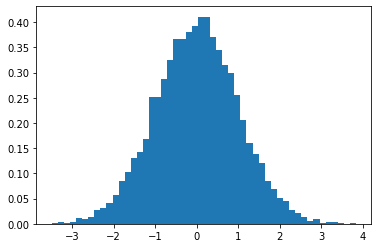

In [ ]:
# Plot a histogram
plt.hist(normal.sample(10000), bins=50, density=True)
plt.show()

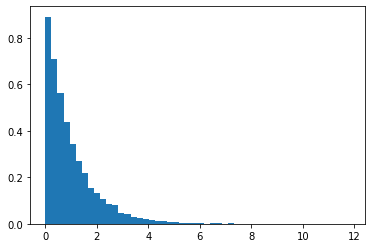

In [ ]:
# Do the same for the exponential distribution
exponential = tfd.Exponential(rate=1)
plt.hist(exponential.sample(10000), bins=50, density=True)
plt.show()

In [ ]:
# Sample as before
exponential.sample(10)

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.3179616 , 0.9595855 , 0.6190708 , 1.3738598 , 1.6796894 ,
       0.40142855, 1.6830153 , 1.78942   , 0.38126466, 0.5528394 ],
      dtype=float32)>

In [ ]:
# Create a Bernoulli distribution (discrete)
bernouilli = tfd.Bernoulli(probs=0.8)
bernouilli.sample(20)

<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1],
      dtype=int32)>

#### Batches of scalar-variate distributions

In [ ]:
# Create a batched Bernoulli distribution

bernoulli_batch = tfd.Bernoulli(probs=[0.1, 0.2, 0.3, 0.5, 0.8])
bernoulli_batch

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[5] event_shape=[] dtype=int32>

In [ ]:
# Sample from it, noting the shape
bernoulli_batch.sample(6)

<tf.Tensor: shape=(6, 5), dtype=int32, numpy=
array([[0, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 1, 1]], dtype=int32)>

In [ ]:
# Use a batch shape with higher rank

probs = [[[0.4, 0.4], 
          [0.11, 0.4], 
          [0.3, 0.7]]]
bernoulli_batch_2D = tfd.Bernoulli(probs=probs)
bernoulli_batch_2D

<tfp.distributions.Bernoulli 'Bernoulli' batch_shape=[1, 3, 2] event_shape=[] dtype=int32>

In [ ]:
# Sample from this batch of distributions
bernoulli_batch_2D.sample(5)

<tf.Tensor: shape=(5, 1, 3, 2), dtype=int32, numpy=
array([[[[0, 0],
         [1, 1],
         [0, 1]]],


       [[[0, 0],
         [0, 1],
         [0, 1]]],


       [[[1, 0],
         [0, 1],
         [0, 1]]],


       [[[1, 0],
         [0, 0],
         [0, 1]]],


       [[[0, 1],
         [0, 1],
         [1, 0]]]], dtype=int32)>

In [ ]:
# Determine probabilities from this batch distribution

bernoulli_batch_2D.prob([[[0, 0], 
                         [1, 0], 
                         [1, 1]]])

<tf.Tensor: shape=(1, 3, 2), dtype=float32, numpy=
array([[[0.6 , 0.6 ],
        [0.11, 0.6 ],
        [0.3 , 0.7 ]]], dtype=float32)>

***
### 3.2. Multivariate or vector-variate Distributions
<a name="multivariate_distributions"></a>
<a id='multivariate_distributions'></a>

#### Basic multivariate distributions

In [ ]:
# Create a 2D multivariate normal with a diagonal covariance

normal_diag = tfd.MultivariateNormalDiag(loc=[0, 1], scale_diag=[1, 4])
normal_diag

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [ ]:
# Sample from it

normal_diag.sample(10)

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[-0.37992278,  3.7348328 ],
       [-2.224005  , -1.5702891 ],
       [ 0.923083  , -3.905779  ],
       [-0.62774605, -1.6770475 ],
       [-0.6252951 , -3.6648293 ],
       [-0.42454168,  1.638437  ],
       [-1.702882  ,  2.7067738 ],
       [-0.4608376 , -2.4047046 ],
       [-1.1919353 , -1.2573128 ],
       [ 0.48053816, -1.538697  ]], dtype=float32)>

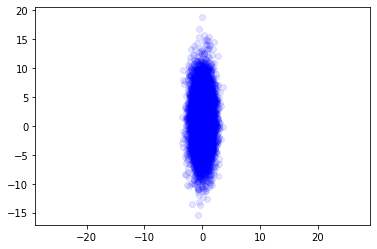

In [ ]:
# Make a plot

plt_sample = normal_diag.sample(10000)
plt.scatter(plt_sample[:, 0], plt_sample[:, 1], color='blue', alpha=0.1)
plt.axis('equal')
plt.show()

Batches of multivariate distributions

In [ ]:
# Create a batch of three two-dimensional multivariate normals:
normal_diag_batch = tfd.MultivariateNormalDiag(loc=[[0,0], [0,0], [0,0]],
                                               scale_diag=[[1,2], [2, 1], [2, 2]])
normal_diag_batch

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[3] event_shape=[2] dtype=float32>

In [ ]:
# Sample from it
samples = normal_diag_batch.sample(5)
samples

<tf.Tensor: shape=(5, 3, 2), dtype=float32, numpy=
array([[[-0.8012545 , -2.128108  ],
        [ 2.0774975 , -2.7921855 ],
        [ 0.52665955,  0.60957587]],

       [[ 0.9923561 , -0.9778331 ],
        [-0.8376892 ,  0.70630246],
        [-1.0894657 , -0.65969497]],

       [[-1.6264789 ,  2.2429497 ],
        [-4.3018756 , -0.7626804 ],
        [-0.4345196 , -0.57022095]],

       [[ 0.7307566 ,  2.8356621 ],
        [ 1.8173586 ,  1.2079152 ],
        [-3.2939956 ,  2.33647   ]],

       [[-0.24759005,  0.56306183],
        [-0.60534286,  0.06578209],
        [ 1.4922864 , -0.55439734]]], dtype=float32)>

In [ ]:
# Compute log probs
normal_diag_batch.log_prob(samples)

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-3.4181342, -6.9686737, -3.3052907],
       [-3.142929 , -2.8681712, -3.426938 ],
       [-4.482594 , -5.135132 , -3.2884164],
       [-3.8031492, -3.6734028, -5.262859 ],
       [-2.6013045, -2.5789928, -3.5409558]], dtype=float32)>

In [ ]:
# Create a sample for a plot -- notice the shape
plt_sample_batch = normal_diag_batch.sample(100000)
plt_sample_batch.shape

TensorShape([100000, 3, 2])

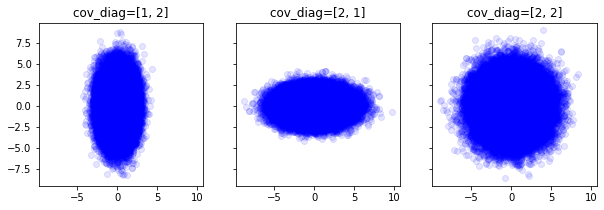

In [ ]:
# Plot samples from the batched multivariate Gaussian

fig, axs = (plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 3)))
titles = ['cov_diag=[1, 2]','cov_diag=[2, 1]', 'cov_diag=[2, 2]']

for i, (ax, title) in enumerate(zip(axs,titles)):
    samples = plt_sample_batch[:,i,:] #take the ith batch [samples x event_shape]
    ax.scatter(samples[:, 0], samples[:, 1], color='blue', alpha=0.1)
    ax.set_title(title)
plt.show()

#### Multivariate Gaussian with full covariance

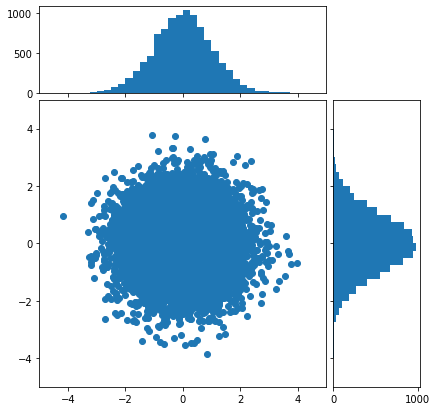

In [ ]:
# Plot the approximate density contours of a 2d spherical Gaussian
spherical_2d_gaussian = tfd.MultivariateNormalDiag(loc=[0., 0.])

N = 10000
x = spherical_2d_gaussian.sample(N)
x1 = x[:, 0]
x2 = x[:, 1]
scatter_histogram(x1, x2, x_lim=[-5, 5], y_lim=[-5, 5])

TFD offers multiple ways to create multivariate normals. 

One possible way to define a multivariate Gaussian distribution with full covariance could be:

1. Specify parameters $\mu$ and either $\Sigma$ (a symmetric positive definite matrix) or $L$ (a lower triangular matrix with positive diagonal elements), such that $\Sigma = LL^T$.

2. If only $\Sigma$ is specified, compute `scale_tril = tf.linalg.cholesky(sigma)`.

3. Create the distribution: `multivariate_normal = tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)`.

In [ ]:
# Initialize a single 3-variate Gaussian distribution.

mu = [1., 2., 3.]

cov = [[ 0.36,  0.12,  0.06],
       [ 0.12,  0.29, -0.13],
       [ 0.06, -0.13,  0.26]]

scale_tril = tf.linalg.cholesky(cov)

multivariate_normal = tfd.MultivariateNormalTriL(loc=mu, scale_tril=scale_tril)

In [ ]:
# Check the covariance matrix. Covariance should agree with cholesky(cov) parameterization.

multivariate_normal.covariance()

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[ 0.36      ,  0.12      ,  0.06      ],
       [ 0.12      ,  0.29      , -0.13      ],
       [ 0.06      , -0.13      ,  0.25999996]], dtype=float32)>

In [ ]:
# Check the mean as well.

multivariate_normal.mean()

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

But we can create multivariate normals including a full-covariance specification as well! Let's plot a 2D full-covariance Gaussian to illustrate this case.



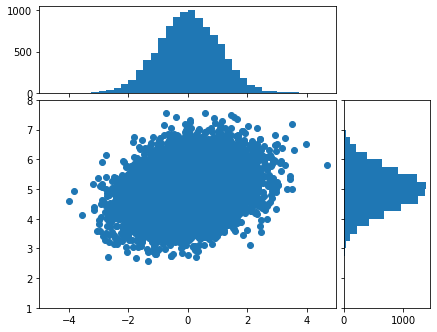

In [ ]:
# Set the mean and covariance parameters

mu = [0., 5]  # mean
cov = [[1.,  0.7],
       [0.2, 0.5]]

nonspherical_2d_gaussian = tfd.MultivariateNormalFullCovariance(
    loc = mu, covariance_matrix = cov)

# Plot density
x = nonspherical_2d_gaussian.sample(10000)
x1 = x[:, 0]
x2 = x[:, 1]
scatter_histogram(x1, x2, x_lim=[-5, 5], y_lim=[1, 8])

Comparing this to the 2d spherical normal we created earlier, what's different?

***
### 3.3. The Independent Distribution
<a name="independent_distribution"></a>
<a id='independent_distribution'></a>

This distribution is useful for regarding a collection of independent, non-identical distributions as a single random variable.

More precisely, a collection of B (independent) E-variate random variables (rv) ${X_1, ..., X_B}$, can be regarded as a [B, E]-variate random variable $(X_1, ..., X_B)$ with probability 

$$p(x_1, ..., x_B) = p_1(x_1) * ... * p_B(x_B)$$

where $p_b(X_b)$ is the probability of the b-th rv. More generally B, E can be arbitrary shapes.



In [ ]:
# combine a batch of two univariate Gaussians into a bivariate Gaussian with independent components
locs = [-1, 1]
scales = [0.5, 1.]
batch_of_normals = tfd.Normal(loc=locs, scale=scales)


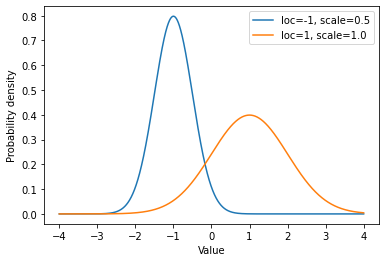

In [ ]:
t = np.linspace(-4, 4, 10000)
densities = batch_of_normals.prob(np.repeat(t[:, np.newaxis], 2, axis=1)) # each column is a vector of densities for one distn

plt.plot(t, densities[:, 0], label=f"loc={locs[0]}, scale={scales[0]}")
plt.plot(t, densities[:, 1], label=f"loc={locs[1]}, scale={scales[1]}")
plt.ylabel('Probability density')
plt.xlabel('Value')
plt.legend()
plt.show()

In [ ]:
# Check their batch_shape and event_shape
batch_of_normals

<tfp.distributions.Normal 'Normal' batch_shape=[2] event_shape=[] dtype=float32>

In [ ]:
# Use Independent to convert the batch shape to the event shape
bivariate_normal_from_Independent = tfd.Independent(batch_of_normals,
                                                   reinterpreted_batch_ndims=1)

In [ ]:
# Note that dimension from batch_shape has shifted to event_shape
bivariate_normal_from_Independent

<tfp.distributions.Independent 'IndependentNormal' batch_shape=[] event_shape=[2] dtype=float32>

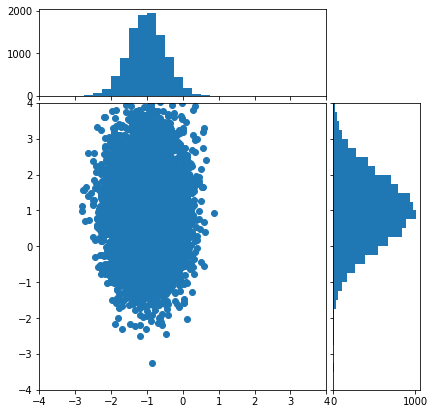

In [ ]:
# Create a plot showing joint density contours and marginal density functions

samples = bivariate_normal_from_Independent.sample(10000)
x1 = samples[:, 0]
x2 = samples[:, 1]
scatter_histogram(x1, x2, x_lim=[-4, 4], y_lim=[-4, 4])

**Use MultivariateNormalDiag to create the equivalent distribution**

In [ ]:
# Note the absence of correlation between single variables!
bivariate_normal_from_Multivariate = tfd.MultivariateNormalDiag(loc=locs, 
                                                                scale_diag=scales)
bivariate_normal_from_Multivariate

<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

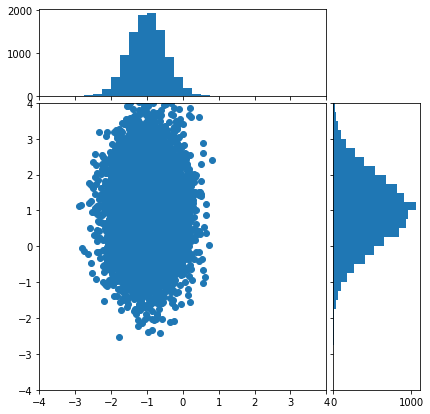

In [ ]:
# Plot the joint density function of bivariate_normal_from_Independent

samples = bivariate_normal_from_Multivariate.sample(10000)
x1 = samples[:, 0]
x2 = samples[:, 1]
scatter_histogram(x1, x2, x_lim=[-4, 4], y_lim=[-4, 4])

***
### 3.4. "Learnable" Distributions
<a name="trainable_distributions"></a>
<a id='trainable_distributions'></a>

We can also make inference about the parameters of a distribution given a sample of data. Let's see how to do that taken the Poisson distribution as an example.

*Remember*: the Poisson distribution is a discrete probability distribution that expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant mean rate and independently of the time since the last event.
Examples of a Poisson distribution could be:
- The number of cases of a disease in different towns;
- The number of particles emitted by a radioactive source in a given
time;
- The number of births per hour during a given day

In [ ]:
# Define a poisson distribution
poisson = tfd.Poisson(rate=10, name='poisson')

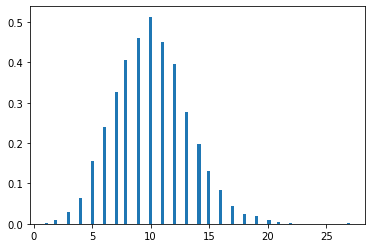

In [ ]:
# Plot it

plt.hist(poisson.sample(5000), bins=100, density=True)
plt.show()

In [ ]:
# Define a poisson distribution with a trainable rate parameter
poisson_train = tfd.Poisson(rate=tf.Variable(1., name='rate'), name='poisson_train')
poisson_train.trainable_variables

(<tf.Variable 'rate:0' shape=() dtype=float32, numpy=1.0>,)

In [ ]:
# Define the negative log likelihood
def nll(x_train, distribution):
    return -tf.reduce_mean(distribution.log_prob(x_train))

In [ ]:
# Define a function to compute the loss and gradients
@tf.function
def get_loss_and_grads(x_train, distribution):
    with tf.GradientTape() as tape:
        #tape.watch(distribution.trainable_variables)
        loss = nll(x_train, distribution)
    grads = tape.gradient(loss, distribution.trainable_variables)
    return loss, grads

In [ ]:
# Optimize to get the rate of the distribution

def poisson_dist_optimisation(data, distribution, display_step=100):

    # Keep results for plotting
    train_loss_results = []
    train_rate_results = []
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.05)

    num_steps = 1000

    for i in range(num_steps):
        loss, grads = get_loss_and_grads(data, distribution)
        optimizer.apply_gradients(zip(grads, distribution.trainable_variables))
        
        rate_value = distribution.rate.value()
        train_loss_results.append(loss)
        train_rate_results.append(rate_value)
        if i % display_step == 0:
            print("Step {:03d}: Loss: {:.3f}: Rate: {:.3f}".format(i, loss, rate_value))
        
    return train_loss_results, train_rate_results

In [ ]:
# Get some data and train
sample_data = poisson.sample(5000)
train_loss_results, train_rate_results = poisson_dist_optimisation(data=sample_data,
                                                                   distribution=poisson_train)

Step 000: Loss: 16.806: Rate: 1.454
Step 100: Loss: 3.139: Rate: 7.104
Step 200: Loss: 2.716: Rate: 8.510
Step 300: Loss: 2.619: Rate: 9.191
Step 400: Loss: 2.591: Rate: 9.562
Step 500: Loss: 2.581: Rate: 9.775
Step 600: Loss: 2.578: Rate: 9.900
Step 700: Loss: 2.577: Rate: 9.975
Step 800: Loss: 2.577: Rate: 10.020
Step 900: Loss: 2.577: Rate: 10.047


In [ ]:
# Predicted value for the rate parameter

pred_value = poisson_train.rate.numpy()
exact_value = poisson.rate.numpy()

print("Exact rate: ", exact_value)
print("Pred rate:  ", pred_value)

Exact rate:  10.0
Pred rate:   10.062889


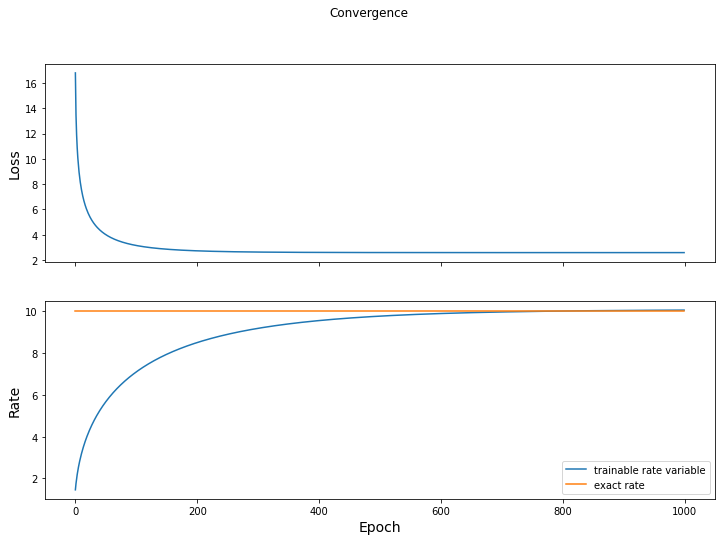

In [ ]:
# Plot to see the convergence of the estimated and true parameters

tensor_exact_value = tf.constant(exact_value, shape=[len(train_rate_results)])

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Convergence')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Rate", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_rate_results, label='trainable rate variable')
axes[1].plot(tensor_exact_value, label='exact rate')
axes[1].legend()
plt.show()

***
## 4. Bayesian Neural Networks
<a name="bayesian_nn"></a>
<a id='bayesian_nn'></a>

So far we have introduced the building blocks to deal with uncertainty in a general framework. Now it is time to apply all of the Bayesian Inference machinery we learnt about before to the problem of neural networks.

__Main definition.__ A Bayesian neural network is a neural network with a prior distribution on its weights. This means that, in contrast with any convential (non-Bayesian) neural network, BNNs are interested not only in the optimal values of the network's parameters -- weights and biases -- but also in the distribution associated with them. Thanks to these distributions we could have a certain level of confidence about the network predictions.

![](https://sanjaykthakur.files.wordpress.com/2018/12/bayes_nn.png?w=700)

_The  idea  behind  Bayesian  neural  networks is to cast the task of training a network as a problem of inference, which is solved using Bayes’ theorem. The latter theorem is mainly used to assign a probability density to each point in the parameter space of the neural network._

__Network training.__ A training iteration consists of a forward-pass and a backward-pass. During a forward pass a single sample is drawn from a variational posterior distribution. It is used to evaluate the approximate cost function. During a backward-pass, gradients of the parameters are calculated via backpropagation so that their values can be updated by an optimizer.

Since a forward pass involves a stochastic sampling step we have to apply the so-called [re-parameterization trick](http://gregorygundersen.com/blog/2018/04/29/reparameterization/) for backpropagation to work.


__Use case.__ In the following sections, we will start our discussion of BDL with the simple case of Regression. In the process we will learn about the types of uncertainties inherent in regression predictions, namely the aleatoric uncertainty and the epistemic uncertainty.

***
### 4.1. Preliminars: The DistributionLambda layer
<a name="lambda_layer"></a>
<a id='lambda_layer'></a>

__DistributionLambda__ is a special Keras layer that uses a Python lambda to construct a distribution conditioned on the layer inputs. Have a look at the following example to understand how it works.

#### Create a probabilistic model using the `DistributionLambda` layer that simulates the 1986 Space Shuttle Challenger disaster.

On January 28, 1986 on the 25th flight of the U.S. Space Shuttle, one of the two solid rocket boosters on the Shuttle Challenger exploded, due to an O-ring failure. Although mission engineers had numerous communications with the manufacturer of the O-ring about damage on previous flights, the manufacturer deemed the risk to be acceptable.
Below, we depict the observations of seven O-ring damage incidents on prior shuttle missions, as a function of ambient temperature. (At 70 degrees, there are two incidents.)

![](https://miro.medium.com/max/1400/0*vyVzMWY5ahNThf_Q)

You’ll note that as the temperature decreases, there’s clearly an increase in proportion of damaged O-rings, yet there’s not an obvious temperature threshold below which the O-rings would likely fail. As with most real-world phenomena, there is uncertainty involved.

We can model the probability p of O-ring damage at temperature t using a logistic function:

$$y = \text{sigmoid}(t) = \frac{1}{1 + \exp(-\beta t + \alpha)}$$

For the sake of simplicity, we will set up the true values of $\beta$ and $\alpha$ as:
$$\beta=1.0$$, 
$$\alpha=0$$

To connect the probability of failure at temperature t, p(t), to the data we can use a Bernoulli random variable with parameter $p(t)$. Note that in general, Ber(p) is a random variable that takes value 1 with probability p, and 0 otherwise. 

**Create a probabilistic sigmoid model with the help of Ber distribution**

4/4 [==============================] - 0s 4ms/step


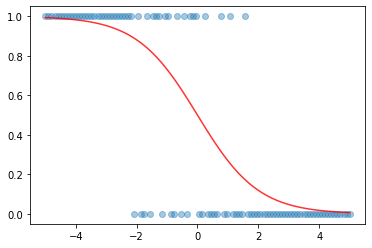

In [ ]:
# Create a sigmoid model, first deterministic, then probabilistic

model = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(1),
          bias_initializer=tf.constant_initializer(0)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=1-t),
                           convert_to_tensor_fn=tfd.Distribution.sample) #tfd.Distribution.mean
])

# Plot the function
x_plot = np.linspace(-5, 5, 100)
plt.scatter(x_plot, model.predict(x_plot), alpha=0.4)
plt.plot(x_plot, 1- 1/(1 + np.exp(-x_plot)), color='r', alpha=0.8)
plt.show()

#### Use the previous model to create probabilistic training data that resemble O-ring damage incidents.

In [ ]:
# Use the model to create 3000 training points

x_train = np.linspace(-5, 5, 3000)[:, np.newaxis]
y_train = model.predict(x_train)


94/94 [==============================] - 0s 3ms/step


Now, let's simulate a training process.

#### Create a new probabilistic model with wrong weights

In [ ]:
# Create a new version of the model, with the wrong weights
model_untrained = Sequential([
    Dense(input_shape=(1,), units=1, activation='sigmoid',
          kernel_initializer=tf.constant_initializer(2),
          bias_initializer=tf.constant_initializer(2)),
    tfpl.DistributionLambda(lambda t: tfd.Bernoulli(probs=1-t),
                           convert_to_tensor_fn=tfd.Distribution.sample) #tfd.Distribution.mean
])

#### Train the new model with the negative loglikelihood


In [ ]:
# Define negative loglikelihood, which we will use for training
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

In [ ]:
# Compile untrained model
model_untrained.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))

In [ ]:
# Train model & save weights after each epoch

epochs = [0]
training_weights = [model_untrained.weights[0].numpy()[0, 0]]
training_bias = [model_untrained.weights[1].numpy()[0]]
for epoch in range(50):
    model_untrained.fit(x=x_train, y=y_train, epochs=1, verbose=False)
    epochs.append(epoch)
    training_weights.append(model_untrained.weights[0].numpy()[0, 0])
    training_bias.append(model_untrained.weights[1].numpy()[0])

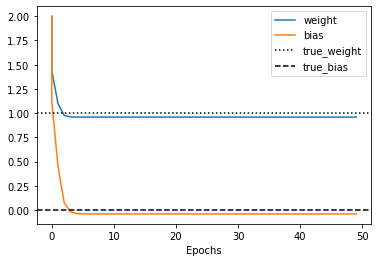

In [ ]:
# Plot the model weights as they train. Note the convergence to the correct values

plt.plot(epochs, training_weights, label='weight')
plt.plot(epochs, training_bias, label='bias')
plt.axhline(y=1, label='true_weight', color='k', linestyle=':')
plt.axhline(y=0, label='true_bias', color='k', linestyle='--')
plt.xlabel('Epochs')
plt.legend()
plt.show()

***
### 4.2. Aleatoric Uncertainty





<a id='aleatoric'></a>

Aleatoric uncertainty refers to the unknowns that differ each time data is collected. This kind of uncertainty is associated with the randomness of the process under consideration (or the observations' noise).




#### Create synthetic data

The data you'll be working with is artifically created from the following equation:
$$ y_i = x_i + \frac{2}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

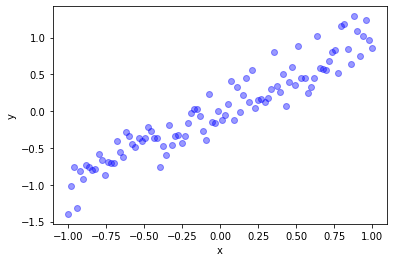

In [ ]:
# Create and plot 100 points of training data

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.2*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, color='blue', alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

#### Deterministic linear regression with MSE loss

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________
4/4 [==============================] - 0s 3ms/step


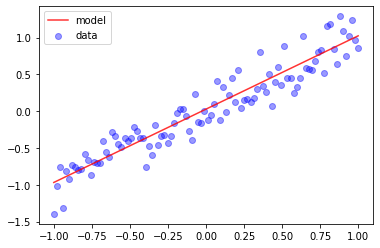

In [ ]:
# Create linear regression via Sequential model
model = Sequential([
    Dense(units=1, input_shape=(1,))
])
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model.summary()
model.fit(x_train, y_train, epochs=200, verbose=False)

# Plot the data and model
plt.scatter(x_train, y_train, alpha=0.4, color='blue', label='data')
plt.plot(x_train, model.predict(x_train), color='red', alpha=0.8, label='model')
plt.legend()
plt.show()

In [ ]:
# Examine the model predictions
x = np.array([[0]])
y_model = model(x)
y_model

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.02705454]], dtype=float32)>

#### Probabilistic linear regression with both user-defined and learned variance


In [ ]:
# a)Create probabilistic regression with normal distribution as final layer
model = Sequential([
    Dense(units=1, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1.)))
])
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1)                 2         
                                                                 
 distribution_lambda_12 (Dis  ((None, 1),              0         
 tributionLambda)             (None, 1))                         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# b) Create probabilistic regression with normal distribution as final layer
model = Sequential([
    Dense(units=1 + 1, input_shape=(1,)),
    tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(
        loc=t[..., :1], scale=tf.math.softplus(t[..., 1:]))))
])
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 2)                 4         
                                                                 
 distribution_lambda_13 (Dis  ((None, 1),              0         
 tributionLambda)             (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# c) Create probabilistic regression with normal distribution as final layer
event_shape=1
model = Sequential([
    Dense(units=tfpl.IndependentNormal.params_size(event_shape), input_shape=(1,)),
    tfpl.IndependentNormal(event_shape=1)
])
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 2)                 4         
                                                                 
 independent_normal_4 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train model using the negative loglikelihood
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.fit(x_train, y_train, epochs=100, verbose=False)

In [ ]:
# Examine the distribution created as a feedforward value
y_model = model(x)
y_model

<tfp.distributions._TensorCoercible 'tensor_coercible' batch_shape=[1] event_shape=[1] dtype=float32>

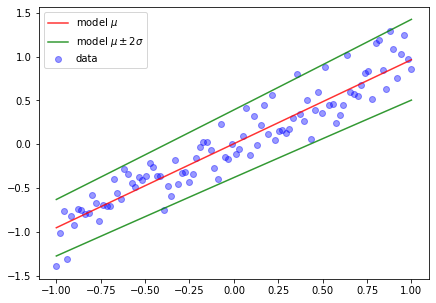

In [ ]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x_train, y_train, color='blue', alpha=0.4, label='data')
ax.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax.legend()
plt.show()

#### Probabilistic linear regression with nonlinear learned mean & variance

Let's change the data to being nonlinear:
$$ y_i = x_i^5 + \frac{1}{10}(1 + x_i)\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

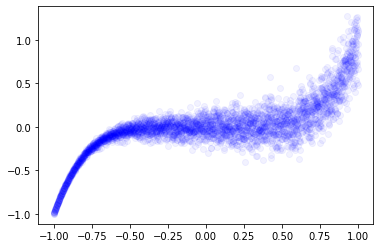

In [ ]:
# Create and plot 3000 data points

n_points = 3000
x_train = np.linspace(-1, 1, n_points)[:, np.newaxis]
y_train = np.power(x_train, 5) + 0.1*(1+x_train)*np.random.randn(n_points)[:, np.newaxis]

plt.scatter(x_train, y_train, color='blue', alpha=0.05)
plt.show()

In [ ]:
# Create probabilistic regression: normal distribution with fixed variance

model = Sequential([
    Dense(input_shape=(1,), units=8, activation='sigmoid'),
    Dense(tfpl.IndependentNormal.params_size(event_shape=1)),
    tfpl.IndependentNormal(event_shape=1)
])
model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.01))
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_21 (Dense)            (None, 8)                 16        
                                                                 
 dense_22 (Dense)            (None, 2)                 18        
                                                                 
 independent_normal_5 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Do inference

model.fit(x_train, y_train, epochs=200, verbose=False)
model.evaluate(x_train, y_train)

94/94 [==============================] - 0s 2ms/step - loss: -1.0520


-1.0520145893096924

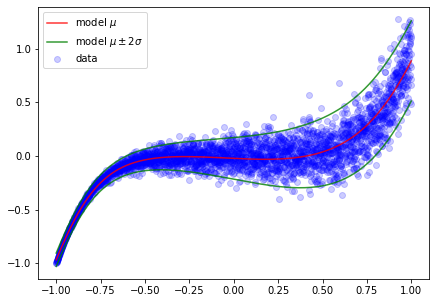

In [ ]:
# Plot the data and a sample from the model

y_model = model(x_train)
y_sample = y_model.sample()
y_hat = y_model.mean()
y_sd = y_model.stddev()
y_hat_m2sd = y_hat - 2 * y_sd
y_hat_p2sd = y_hat + 2 * y_sd

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x_train, y_train, color='blue', alpha=0.2, label='data')
ax.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
ax.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
ax.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
ax.legend()
plt.show()

***
### 4.3. Epistemic Uncertainty & DenseVariational layer
<a name="epistemic"></a>
<a id='epistemic'></a>

Epistemic uncertainty captures our ignorance about the models most suitable to explain the data. The unknown factors in our model, for instance, can be categorised as epistemic uncertainty.

In the previous models, weights were estimated in an exact way. Now, we assume that the weights are normally distributed. 

In order to train the neural network, we use variational inference through the use of the DenseVariational layer.

#### Create linear data with Gaussian noise

The data you'll be working with is the same as you used before:
$$ y_i = x_i + \frac{2}{10}\epsilon_i$$
where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed. We'll be running a Bayesian linear regression on this data.

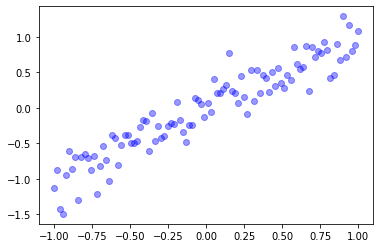

In [ ]:
# Use the same data as before -- create and plot 100 data points

x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.2*np.random.randn(100)[:, np.newaxis]

plt.scatter(x_train, y_train, color='blue', alpha=0.4)
plt.show()

#### Create the prior and posterior distribution for model weights

In [ ]:
# Define the prior weight distribution -- all N(0, 1) -- and not trainable
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n),
                                                scale_diag=tf.ones(n)))
    ])
    return prior_model

In [ ]:
# Define variational posterior weight distribution -- multivariate Gaussian
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n),
                          dtype=dtype),
        tfpl.MultivariateNormalTriL(n)
    ])
    return posterior_model

#### Create the model with `DenseVariational` layers

In [ ]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution
model = Sequential([
    tfpl.DenseVariational(input_shape=(1,),
                         units=1,
                         make_prior_fn=prior,
                         make_posterior_fn=posterior,
                         kl_weight=1/x_train.shape[0],
                         kl_use_exact=True)
])
model.compile(loss=tf.keras.losses.MeanSquaredError(),
             optimizer=RMSprop(learning_rate=0.005))
model.summary()


Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_3 (DenseV  (None, 1)                5         
 ariational)                                                     
                                                                 
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#### Train model
model.fit(x_train, y_train, epochs=500, verbose=False)

In [ ]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [0.9900013 0.0088253]
posterior covariance:  [0.01718809 0.00043759]
                       [0.00043759 0.00595422]


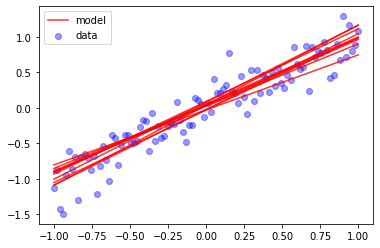

In [ ]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.scatter(x_train, y_train, color='blue', alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

<div class  = "alert alert-info"> 
How do you think the size of the dataset will affect the epistemic model?
</div>

***
### Aleatoric + Epistemic Uncertainty
<a name="aleatoric+epistemic"></a>

We can include both types of uncertainty in our model. For each of the models considered due to epistemic uncertainty, we can incorporate aleatoric uncertainty.

Work with the nonlinear dataset:
$$ y_i = x_i^5 + \frac{1}{10}(1 + x_i)\epsilon_i$$


Now, put it all together and create a nonlinear probabilistic regression with weight uncertainty

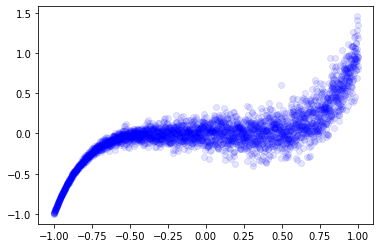

In [ ]:
# Create and plot 3000 data points

n_points = 3000
x_train = np.linspace(-1, 1, n_points)[:, np.newaxis]
y_train = np.power(x_train, 5) + 0.1*(1+x_train)*np.random.randn(n_points)[:, np.newaxis]

plt.scatter(x_train, y_train, color='blue', alpha=0.1)
plt.show()

In [ ]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational_4 (DenseV  (None, 8)                152       
 ariational)                                                     
                                                                 
 dense_variational_5 (DenseV  (None, 2)                189       
 ariational)                                                     
                                                                 
 independent_normal_6 (Indep  ((None, 1),              0         
 endentNormal)                (None, 1))                         
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model

model.fit(x_train, y_train, epochs=500, verbose=False)
model.evaluate(x_train, y_train)

94/94 [==============================] - 1s 3ms/step - loss: -0.7625


-0.7625480890274048

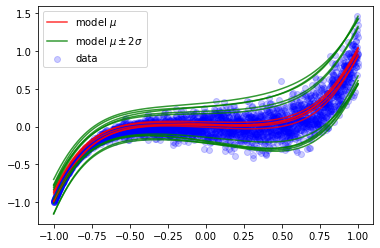

In [ ]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, color='blue', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()

***
### 4.4. Dropout & Epistemic Uncertainty
<a name="dropout"></a>
<a id='dropout'></a>

Dropout (Hinton et al) is a technique used to avoid over-fitting in a model. In essence, dropout zeros out neurons randomly according to a Bernoulli distribution. 

In the context of Bayesian Deep Learning, dropout can be seen as a Gaussian process approximation. In order to get uncertainty estimates from dropout, we just have to apply it both when performing training and prediction steps.


![](https://www.yuritan.nl/img/prediction_uncertainty/dropout.gif)

Every time you do a forward pass, some hidden states are masked out. This results in a slightly different network architecture every time you do a prediction. And if you repeat this many times, you have many slightly different models, predicting different values.

Let's code it!

**Create data**

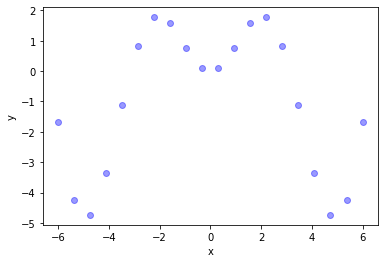

In [ ]:
# Create nonlinear dataset as in http://www.cs.ox.ac.uk/people/yarin.gal/website/bdl101/, and plot it
x_train = np.linspace(0, 1, 20)
x_train = x_train * 12 - 6
y_train = x_train * np.sin(x_train)

plt.scatter(x_train, y_train, color='blue', alpha=0.4)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

**Create model with dropout**

In [ ]:
# Create model with dropout. Note the training=True parameter in Dropout layers

inputs = tf.keras.layers.Input(shape=(1,))
x = Dense(512, activation="relu")(inputs)
x = tf.keras.layers.Dropout(0.5)(x, training=True)
x = Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x, training=True)
outputs = Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss="mean_squared_error", optimizer="adam")

**Train the model**

In [ ]:
# Train the model

model.fit(x_train, y_train, epochs=2000, verbose=0)

**Plot the predictive distribution of our dropout neural network**

In [ ]:
x_test = np.linspace(0, 1, 100)
x_test = x_test * 20 - 10

# do stochastic forward passes on x_test:
samples = [model.predict(x_test) for _ in range(500)]
m = np.mean(samples, axis=0).flatten() # predictive mean
v = np.var(samples, axis=0).flatten() # predictive variance

# plot mean and uncertainty
plt.plot(x_train, y_train, 'or')
plt.plot(x_test, m, 'gray')
plt.fill_between(x_test, m - 2*v**0.5, m + 2*v**0.5, 
                 color='lightblue', alpha=0.5) # plot two std (95% confidence)

***
### 4.5. Reparameterization layers
<a name="reparameterization_layer"></a>
<a id='reparameterization_layer'></a>

These kind of layers implement the Bayesian variational inference analogue to their deterministic layer counterparts by assuming the kernel and/or the bias are drawn from distributions. By default, the layers implement a stochastic forward pass via sampling from the kernel and bias posteriors.

**Load in the MNIST dataset**

The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

In [ ]:
# Model / data parameters
num_classes = 10
input_shape = (28, 28, 1)

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

11490434/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


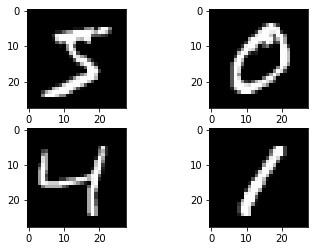

In [ ]:
# Inspect some of the data by making plots
img_rows, img_cols = 28, 28
x = x_train.reshape(x_train.shape[0], img_rows, img_cols)
for i, j in enumerate([221, 222, 223, 224]):
    plt.subplot(j)
    plt.imshow(x[i], cmap=plt.get_cmap('gray'))
plt.show()

In [ ]:
def create_dataset(x, y): 
    dataset = tf.data.Dataset.from_tensor_slices((x , y)).shuffle(len(x)-1)
    dataset = dataset.batch(128)
    return dataset

train_dataset = create_dataset(x_train, y_train)

#### 2D deterministic convolutional neural network

In [ ]:
# Create standard deterministic model with:
# - Conv2D
# - MaxPooling
# - Conv2D
# - MaxPooling
# - Flatten
# - Dense with Softmax
model = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense_26 (Dense)            (None, 10)              

#### Probabilistic 2D convolutional neural network, with both weight and output uncertainty

In [ ]:
# Create probablistic model with the following layers:
# - Conv2D
# - MaxPooling
# - Conv2D
# - MaxPooling
# - Flatten
# - Dense
# - OneHotCategorical

divergence_fn = lambda q, p, _: tfd.kl_divergence(q, p) / x_train.shape[0]

model = Sequential([
    tfpl.Convolution2DReparameterization(input_shape=input_shape, 
                                         filters=32, kernel_size=(3, 3), 
                                         activation='relu',
                                         kernel_prior_fn=tfpl.default_multivariate_normal_fn, 
                                         kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         kernel_divergence_fn=divergence_fn,
                                         bias_prior_fn=tfpl.default_multivariate_normal_fn, 
                                         bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         bias_divergence_fn=divergence_fn),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tfpl.Convolution2DReparameterization(filters=64, kernel_size=(3, 3), 
                                         activation='relu',
                                         kernel_prior_fn=tfpl.default_multivariate_normal_fn, 
                                         kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         kernel_divergence_fn=divergence_fn,
                                         bias_prior_fn=tfpl.default_multivariate_normal_fn, 
                                         bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         bias_divergence_fn=divergence_fn),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(num_classes), 
                                activation=None,
                                kernel_prior_fn=tfpl.default_multivariate_normal_fn, 
                                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                kernel_divergence_fn=divergence_fn,
                                bias_prior_fn=tfpl.default_multivariate_normal_fn, 
                                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                bias_divergence_fn=divergence_fn),
    tfpl.OneHotCategorical(num_classes)
])
model.summary()

/usr/local/lib/python3.8/dist-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.8/dist-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 26, 26, 32)       640       
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_reparameterization_1  (None, 11, 11, 64)       36992     
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)            

In [ ]:
# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [ ]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [ ]:
# Train the model
model.fit(x_train, y_train, batch_size = 128, epochs=15, verbose=False)
model.evaluate(x_train, y_train)
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.3503 - accuracy: 0.9754


[0.3502580523490906, 0.9753999710083008]

**How does the uncertainty evolve as training step makes higher?**

In [ ]:
# Repeat the same architecture as before
# - Conv2D
# - MaxPooling
# - Conv2D
# - MaxPooling
# - Flatten
# - Dense
# - OneHotCategorical

model = Sequential([
    tfpl.Convolution2DReparameterization(input_shape=input_shape, 
                                         filters=32, kernel_size=(3, 3), 
                                         activation='relu',
                                         kernel_prior_fn=tfpl.default_multivariate_normal_fn, 
                                         kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         kernel_divergence_fn=divergence_fn,
                                         bias_prior_fn=tfpl.default_multivariate_normal_fn, 
                                         bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         bias_divergence_fn=divergence_fn),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tfpl.Convolution2DReparameterization(filters=64, kernel_size=(3, 3), 
                                         activation='relu',
                                         kernel_prior_fn=tfpl.default_multivariate_normal_fn, 
                                         kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         kernel_divergence_fn=divergence_fn,
                                         bias_prior_fn=tfpl.default_multivariate_normal_fn, 
                                         bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                         bias_divergence_fn=divergence_fn),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(num_classes), 
                                activation=None,
                                kernel_prior_fn=tfpl.default_multivariate_normal_fn, 
                                kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                kernel_divergence_fn=divergence_fn,
                                bias_prior_fn=tfpl.default_multivariate_normal_fn, 
                                bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                bias_divergence_fn=divergence_fn),
    tfpl.OneHotCategorical(num_classes)
])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization_2  (None, 26, 26, 32)       640       
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_reparameterization_3  (None, 11, 11, 64)       36992     
  (Conv2DReparameterization)                                     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)            

In [ ]:
# customize the learning algorithm of your model 

@tf.function
def custom_train(x, y, l):
    with tf.GradientTape() as tape:
        y_pred = model(x)
        kl = sum(model.losses) / l
        loss_value = nll(y, y_pred) + kl
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value

In [ ]:
# Plot both the real image and (a sample of) the output distribution

def plot_bcnn(results, x_test=x_test, indices=[7274, 921, 4699, 8027, 5845, 1028]):
    for i, j in enumerate(indices):
        fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
        ax1 = axs[0]
        ax1.imshow(np.squeeze(x_test[j]), cmap=plt.get_cmap('gray'))
        ax2 = axs[1]
        ax2.hist(results[:, i])
        ax2.set_xlim([0, 10])
        plt.show()

*******************************************
***********Epoch: 0; step: 0 **************
*******************************************


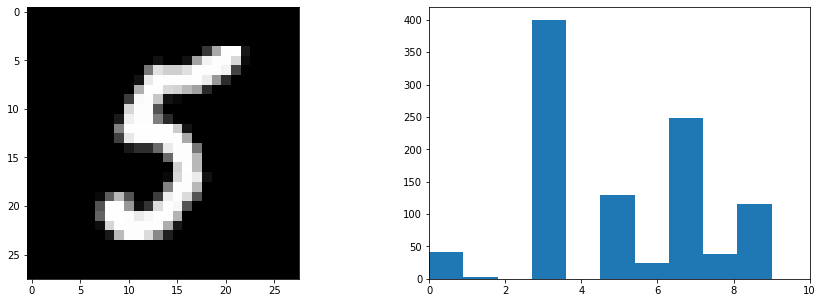

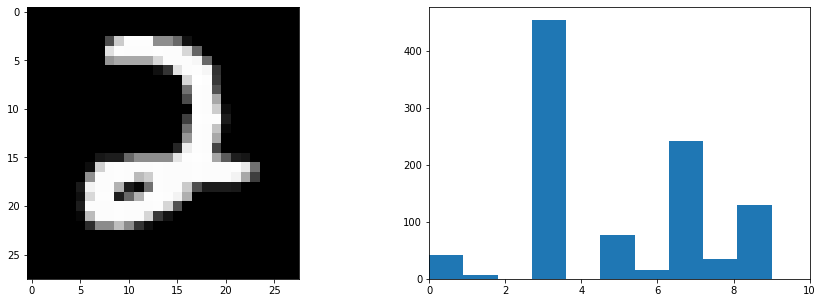

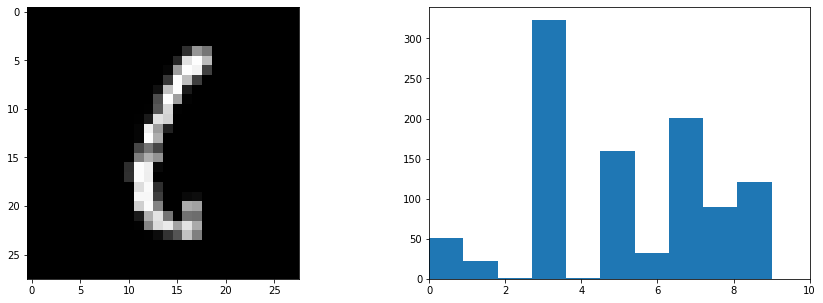

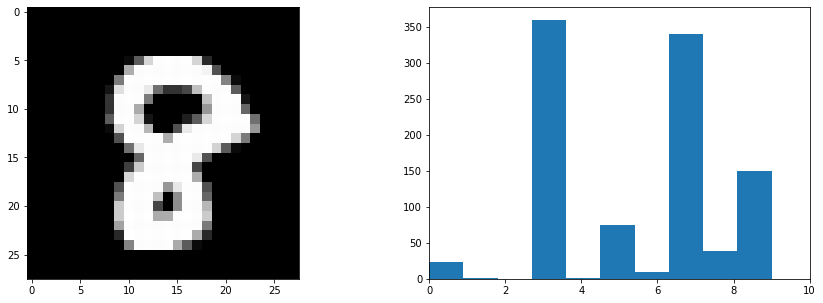

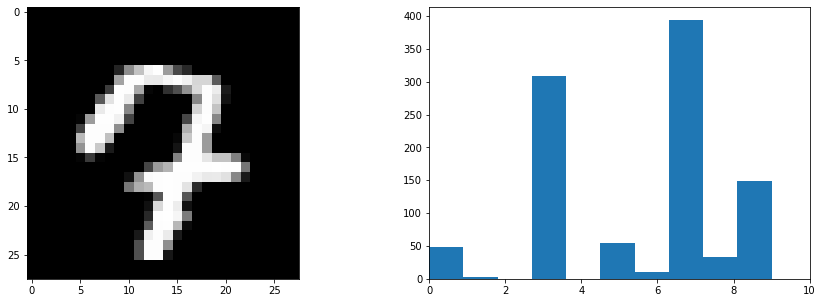

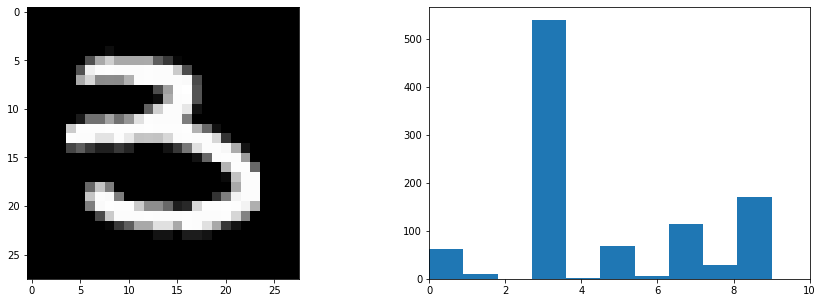

*******************************************
***********Epoch: 1; step: 0 **************
*******************************************


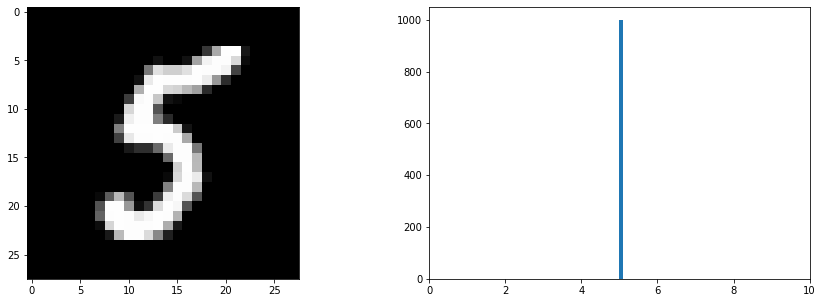

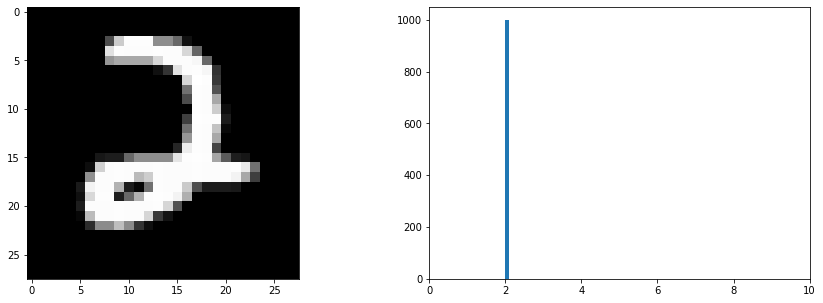

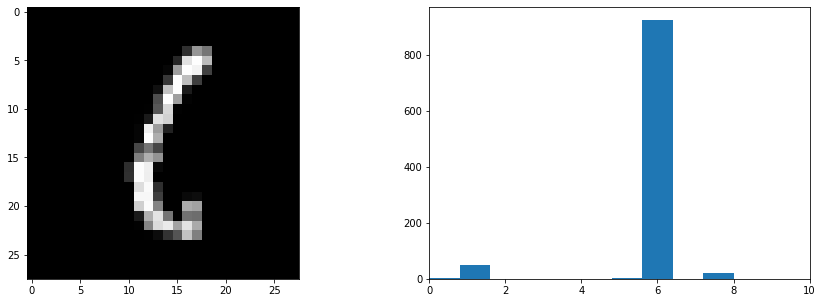

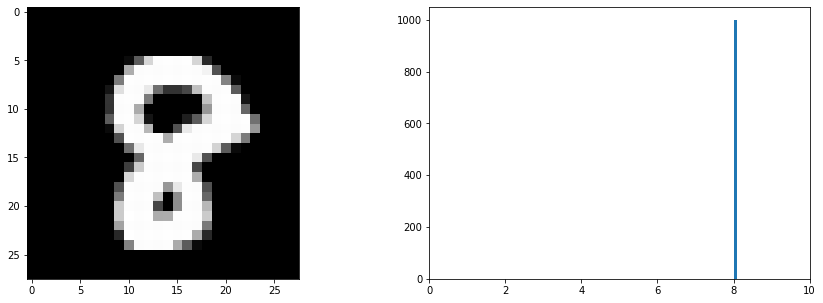

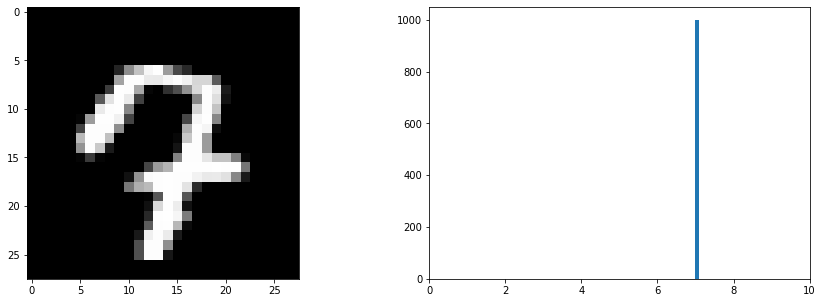

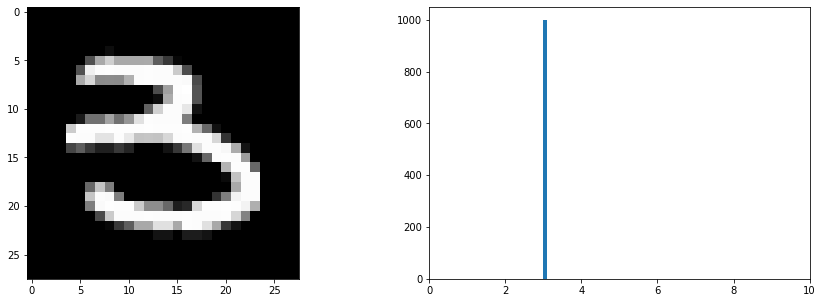

In [ ]:
# Train the model and see how the uncertainty evolves over epochs

epochs = 2
# images sample
vizdata = x_test[[7274, 921, 4699, 8027, 5845, 1028]]

optimizer = RMSprop(learning_rate=0.005)
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_dataset):
        loss_ = custom_train(x, y, len(x_train))
        if (i==0) | (i % 500 == 0):
            print('*'*43)
            print('***********Epoch: %d; step: %d **************' % (epoch, i))
            print('*'*43)
            results = np.array([tf.argmax(model(vizdata), axis=1).numpy().tolist() for i in range(1000)])
            plot_bcnn(results)

## References

https://www.yuritan.nl/posts/prediction_uncertainty/

https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/A_Tour_of_TensorFlow_Probability.ipynb

https://www.tensorflow.org/probability/examples/TensorFlow_Distributions_Tutorial#batches_of_multivariate_distirbutions

https://www.tensorflow.org/probability/examples/Probabilistic_Layers_Regression

